# Sellers Data Analysis

Goal: Identify sellers who repeatedly perform poorly and why. Perhaps this can be used to help us respond to the CEO's request to improve Olist's profit margins.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


In [2]:
# Plot distribution of numerical variables in sellers dataset

from olist.seller import Seller
seller = Seller()
sellers = seller.get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,revenue,profits_before_it_costs
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870,201.870,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,15.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2290.307,2050.307,2370.307,2130.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,1.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,15.800,15.800,95.800,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,1.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,7.999,7.999,87.999,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,1.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,16.799,-83.201,96.799,-3.201


In [3]:
sellers.describe()

,delay_to_carrier,wait_time,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,revenue,profits_before_it_costs
count,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000
mean,0.402786,12.160414,6.619192,0.124570,0.592130,4.086880,562.131313,33.617508,38.085185,1.162150,4566.515906,938.213880,376.082567,986.186944,424.055631
std,2.391687,7.103208,5.914010,0.191870,0.279057,0.810166,1941.000427,107.133714,122.417269,0.443348,14185.211617,1660.107616,1276.183916,1655.679175,1274.295160
min,0.000000,1.214178,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,6.500000,0.650000,-22499.517000,80.650000,-22419.517000
25%,0.000000,8.289263,1.000000,0.000000,0.478261,3.818424,0.000000,2.000000,3.000000,1.000000,239.800000,119.946750,19.892500,173.099250,93.000000
50%,0.000000,11.120969,4.000000,0.063856,0.600000,4.200000,100.000000,7.000000,8.000000,1.000000,893.500000,460.221000,250.859500,504.049000,285.790500
75%,0.000000,14.240673,10.000000,0.166667,0.750000,4.625000,380.000000,23.000000,26.000000,1.152009,3586.022500,1183.160250,676.667750,1223.955000,720.593750
max,45.434039,189.863160,23.000000,1.000000,1.000000,5.000000,40890.000000,1854.000000,2039.000000,15.000000,229472.630000,24387.263000,17967.605000,24387.263000,17967.605000


In [4]:
sellers.describe().columns

Index(['delay_to_carrier', 'wait_time', 'months_on_olist',
       'share_of_one_stars', 'share_of_five_stars', 'review_score',
       'cost_of_reviews', 'n_orders', 'quantity', 'quantity_per_order',
       'sales', 'revenues', 'profits', 'revenue', 'profits_before_it_costs'],
      dtype='object')

In [6]:

# plt.figure(figsize=(15,11))


# #select columns that are numerical variables for plotting distribution
# numerical_features = ['delay_to_carrier', 'wait_time', 'months_on_olist',
#        'share_of_one_stars', 'share_of_five_stars', 'review_score',
#        'cost_of_reviews', 'n_orders', 'quantity', 'quantity_per_order',
#        'sales', 'revenues', 'profits', 'revenue', 'profits_before_it_costs']


# for (i, col) in enumerate(numerical_features):
#     plt.subplot(3,5,i+1)
#     sns.histplot(sellers[col], kde=False, stat='density', discrete=True)
 
    

# Plots - Distribution

In [7]:
# delay_to_carrier: average time (days) per seller, if seller passes order to carrier after shipping deadline. This would represent
# any delay in the customer's order attributable to the seller

# wait_time: average time (days) per seller, calculated from purchase to final delivery to customer. Since wait_time includes the time
# a seller ships to the carrier, it is correlated with delay_to_carrier. 


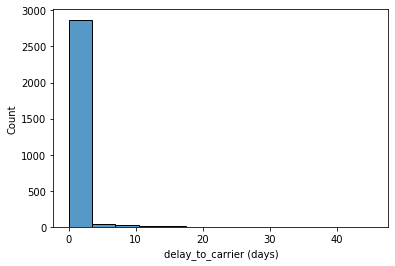

In [40]:
# delay_to_carrier.histogram
sns.histplot(sellers['delay_to_carrier'])
plt.xlabel('delay_to_carrier (days)')

                     

In [33]:
#How many sellers contribute to delays?
num_sellers_delay = len((sellers[sellers['delay_to_carrier'] > 0]))
num_sellers_delay

243

In [32]:
#What percentage of sellers contribute to delays?
round(num_sellers_delay / len(sellers), 2) * 100

8.0

In [35]:
# What is the average review score for sellers that have delayed shipment to carriers?
sellers[sellers['delay_to_carrier'] > 0].review_score.mean()


3.3051861527612707

In [36]:
#How does that compare to the review score of all sellers? 
sellers.review_score.mean()

4.086880345061921

With sellers who have had delayed shipment to carriers, there is a 0.78 (4.09 - 3.31) decrease in avg. review score. Let's keep 'delay_to_carrier' as a feature to include in OLS Regression since it appears to have an impact on customer reviews.

In [ ]:
# wait_time.histogram

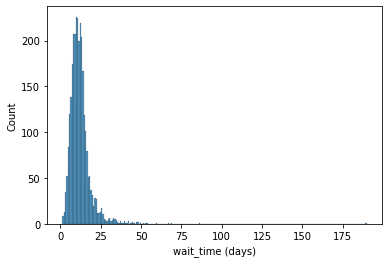

In [44]:
sns.histplot(sellers.wait_time)
plt.xlabel('wait_time (days)');

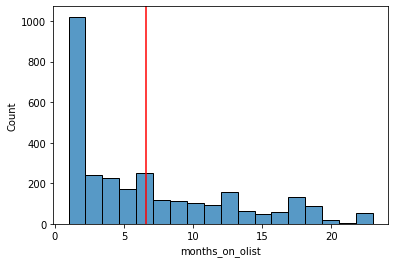

In [50]:
# months_on_olist: how long the seller has been on the platform. This serves as a proxy for experience, but also
# for sellers to establish a reputation on the platform
sns.histplot(sellers.months_on_olist)
plt.axvline(x=sellers.months_on_olist.mean(), color='red');


Appears to be many new sellers on Olist platform. Include 'months_on_olist' as feature in OLS regression to see impact 
on customer reviews

### Features based on order quantity 

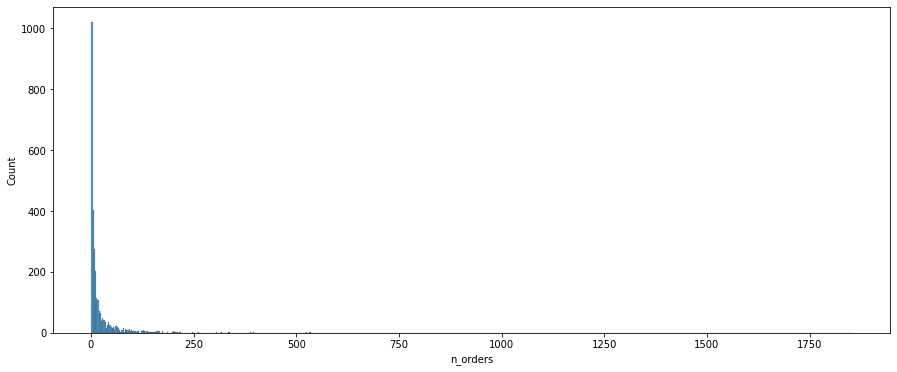

In [62]:
# 'n_orders': number of orders the seller has had on the platform. This also can help serve as a proxy for experience in
# handling orders.  
plt.figure(figsize=(15, 6))
sns.histplot(sellers.n_orders);


Here we can see a large right skewed distribution of orders transacted by sellers. In fact the median 'n_order' is 7, and 75% of the sellers have had less than 23 orders on the platform. 

/Users/atat/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


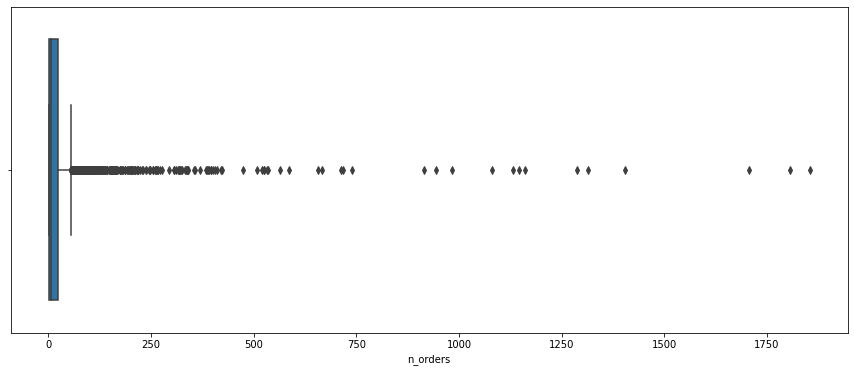

In [66]:
plt.figure(figsize=(15,6))
sns.boxplot(sellers.n_orders);

In [ ]:
# quantity: the total number of individual items sold by seller
# quantity_per_order: the average number of items per order for the seller. Derived from 'n_orders' and 'quantity'

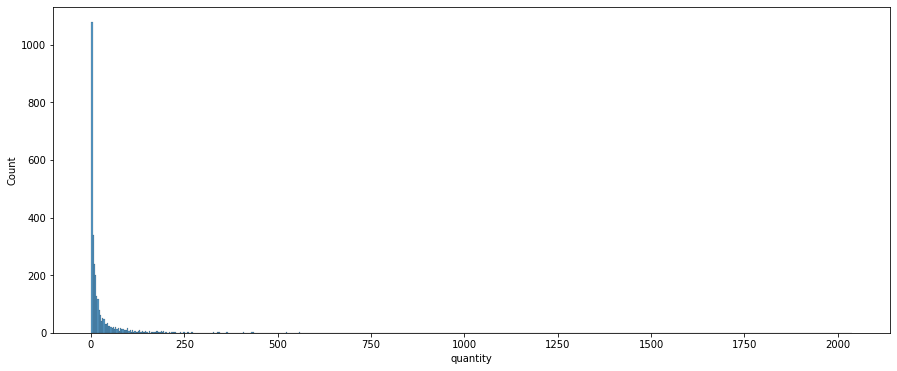

In [68]:
# quantity.histogram
plt.figure(figsize=(15,6))
sns.histplot(sellers.quantity);

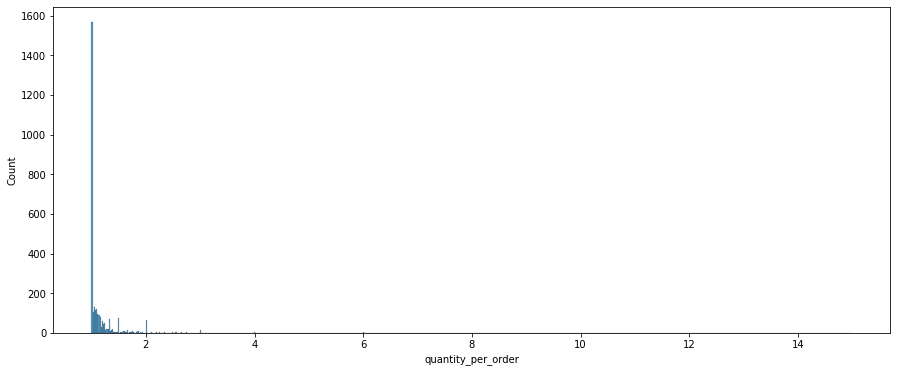

In [71]:
# quantity_per_order
plt.figure(figsize=(15,6))
sns.histplot(sellers.quantity_per_order);

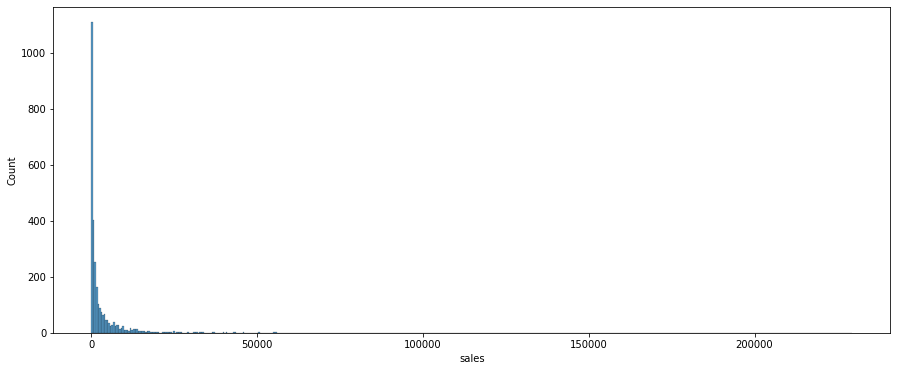

In [82]:
# sales: total sales for seller on platform 
#sales.histogram

plt.figure(figsize=(15, 6))
sns.histplot(sellers.sales);

/Users/atat/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


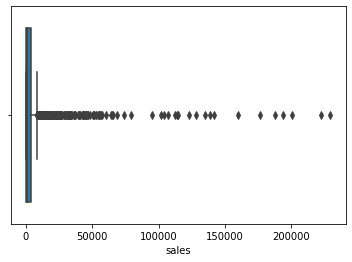

In [ ]:
# TARGET VARIABLES: feedback from customer via reviews
# share_of_one_stars: proportion of all reviews seller received that got five stars
# share_of_five_stars: proportion of all reviews seller received that got one star
# review_score: average score of all reviews seller received

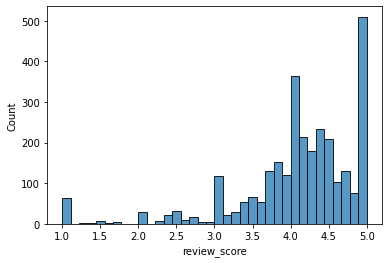

In [73]:
#review_score.histogram

sns.histplot(sellers.review_score);



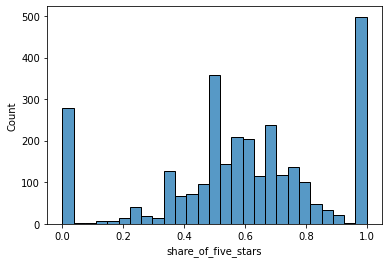

In [76]:
#share_of_five_stars.histogram
sns.histplot(sellers.share_of_five_stars);


There is a W-shaped distribution here. A large number of sellers have only ever gotten five-star reviews, while we see smaller peaks at both a) received 5-stars for half their transactions, and b) in none of their transactions. For a more fair assessment that takes into account the number of reviews a seller has received, we could find assign a weight to each 5-star review, so it's proportional to the number of total reviews received. 

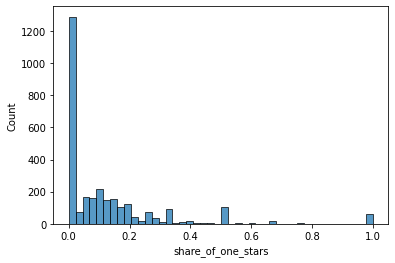

In [78]:
#share_of_one_stars.histogram
sns.histplot(sellers.share_of_one_stars);


The vast majority of sellers don't receive any one-star reviews.

# Model out review_score with OLS

In [80]:
#Applying some feature scaling. Due to large number of outliers among the features, will use standardization over normalization 
#since it does not require scaling based on the range of values. 

def standardize(df, features): 
    df_standardized = df.copy()
    for f in features:
        mu = df[f].mean()
        sigma = df[f].std()
        df_standardized[f] = df[f].map(lambda x: (x - mu) / sigma)
    return df_standardized


In [87]:
# Select features and run a multi-variate linear regression model to determine how much each feature impacts review score
features = ['delay_to_carrier', 'wait_time', 'months_on_olist', 'n_orders', 'quantity', 'quantity_per_order', 'sales']
sellers_standardized = standardize(sellers, features)
model = smf.ols(formula=f"review_score ~ {'+ '.join(features)}", data=sellers_standardized).fit()

In [89]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     106.3
Date:                Tue, 03 Aug 2021   Prob (F-statistic):          3.46e-139
Time:                        16:17:58   Log-Likelihood:                -3255.8
No. Observations:                2970   AIC:                             6528.
Df Residuals:                    2962   BIC:                             6575.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.0869      0.013    307.144      0.000       4.061       4.113
delay_to_carrier      -0.1329      0.015     -8.716      0.000      -0.163      -0.103
wait_time             -0.2765      0.015    -18.150      0.000      -0.306      -0.247
months_on_olist       -0.0082      0.015     -0.553      0.580      -0.037       0.021
n_orders               0.1052      0.118      0.888      0.374      -0.127       0.337
quantity              -0.1161      0.117     -0.991      0.322      -0.346       0.114
quantity_per_order    -0.0447      0.014     -3.308      0.001      -0.071      -0.018
sales                  0.0088      0.022      0.396      0.692      -0.035       0.052
==============================================================================
Omnibus:                      813.774   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2772.176
Skew:                          -1.351   Prob(JB):                         0.00
Kurtosis:                       6.886   Cond. No.                         21.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpretation of Results:

- This model has a low R2 (~0.20) suggesting that the currently selected features only explain 20% of the variance
found in the review scores. The f-proba shows that our R2 is statistically significant and that
it performs better than a model without any features.
- The coefficients for the features 'months_on_olist', 'n_orders', 'quantity', and 'sales' are not statistically significant as their p-values are not less than 0.05. Additionally, we see that a value of 0 falls within the 95% confidence interval. Since a zero coefficient would indicate that the feature has no impact on the target variable (i.e. what we state with the null hypothesis), we can't reject the null hypothesis and the coefficients are not reliable (statistically significant). Consider removing[??].


In [96]:
# REVISED FEATURE SELECTION
features = ['delay_to_carrier', 'wait_time', 'quantity_per_order']
sellers_standardized = standardize(sellers, features)
revised_model = smf.ols(formula=f"review_score ~ {'+ '.join(features)}", data=sellers_standardized).fit()

In [97]:
revised_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     247.7
Date:                Tue, 03 Aug 2021   Prob (F-statistic):          2.08e-143
Time:                        18:06:20   Log-Likelihood:                -3256.6
No. Observations:                2970   AIC:                             6521.
Df Residuals:                    2966   BIC:                             6545.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.0869      0.013    307.268      0.000       4.061       4.113
delay_to_carrier      -0.1315      0.015     -8.710      0.000      -0.161      -0.102
wait_time             -0.2776      0.015    -18.391      0.000      -0.307      -0.248
quantity_per_order    -0.0468      0.013     -3.519      0.000      -0.073      -0.021
==============================================================================
Omnibus:                      797.448   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2693.675
Skew:                          -1.326   Prob(JB):                         0.00
Kurtosis:                       6.838   Cond. No.                         1.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
model.params

Intercept             4.086880
delay_to_carrier     -0.132853
wait_time            -0.276461
months_on_olist      -0.008158
n_orders              0.105213
quantity             -0.116118
quantity_per_order   -0.044664
sales                 0.008822
dtype: float64

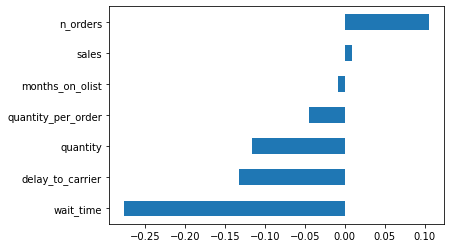

In [91]:
model.params[1:].sort_values().plot(kind='barh');

In [92]:
model.rsquared

0.20074928674431547

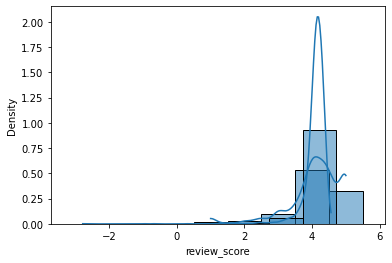

In [93]:
sns.histplot(sellers['review_score'], kde=True, stat='density', discrete=True)
sns.histplot(model.predict(sellers_standardized[features]), kde=True, stat='density', discrete=True);


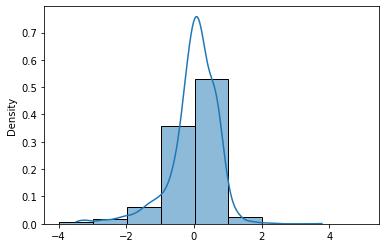

In [94]:
sns.histplot(model.resid, kde=True, stat='density', discrete=True);

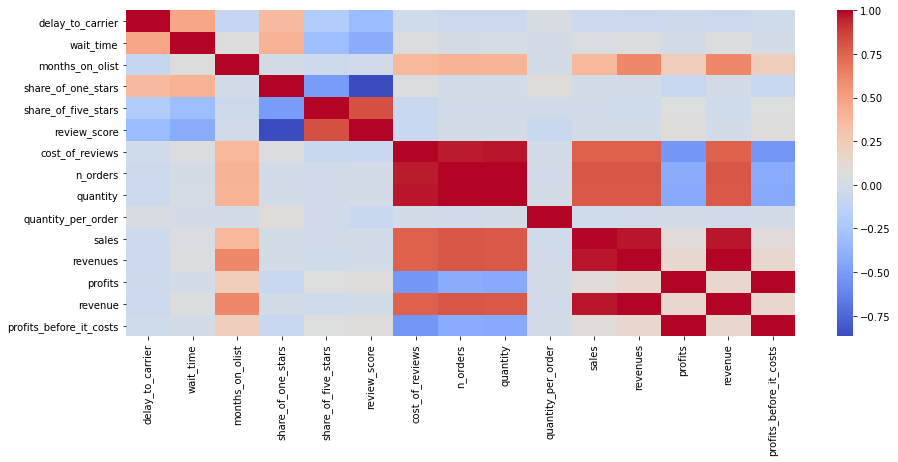

In [99]:
plt.figure(figsize=(15,6))
sns.heatmap(sellers.corr(), cmap='coolwarm');

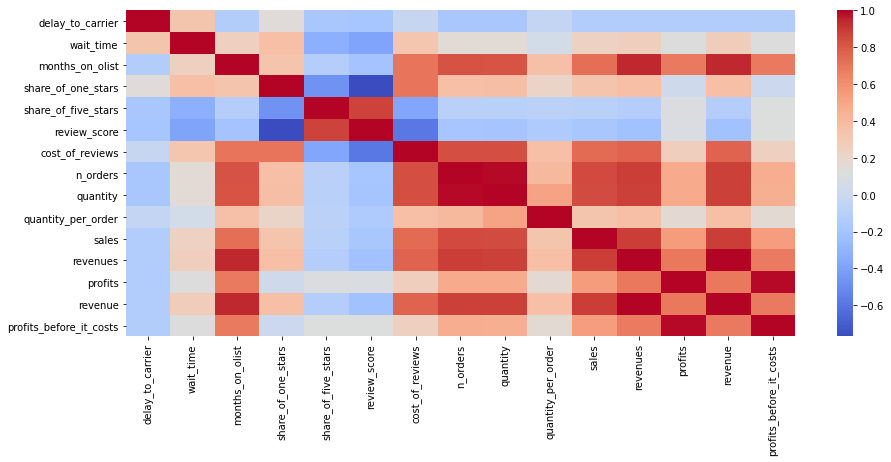

In [100]:
plt.figure(figsize=(15,6))
sns.heatmap(sellers.corr(method='spearman'), cmap='coolwarm');

# for SPearman = One of the variable is categorical and ordered (ordinal).